In [7]:
import open3d as o3d
import numpy as np
import os
import glob
import pandas as pd
import pymeshlab as pml
import time
import matplotlib as plt
import sys
sys.path.append('../preprocessing')
import pickle as pkl
# from viz import viz_mesh

In [9]:
with open("./querying/normalized_features_final_with_silhouettes.pkl", 'rb') as file:
    newdf = pkl.load(file)

In [ ]:
import pickle as pkl
with open("./querying/paths.pkl", 'rb') as file:
    path = pkl.load(file)
true_classes = [p.split("/")[-1].split("\\")[0] for p in path]
objnames = [p.split("/")[-1].split("\\")[1] for p in path]
true_classes, objnames

In [10]:
features_np = newdf.to_numpy()
features_np.shape

(2466, 1038)

In [55]:
import numpy as np
from pynndescent import NNDescent

# Generate some sample data
np.random.seed(42)
data = features_np
# Create an NNDescent index
index = NNDescent(data)

# Query for approximate nearest neighbors
query_vector = data[99]
topk = 10
n_neighbors = topk + 1

indices, distances = index.query([query_vector], k=n_neighbors)

# Convert indices to integers
indices = indices.astype(int)

# Retrieve the actual vectors for the approximate neighbors
nearest_neighbor_vectors = data[indices[0]]

# Print results
print("Approximate Nearest Neighbors:")
print(nearest_neighbor_vectors)
print("Distances:")
print(distances)


Approximate Nearest Neighbors:
[[-0.50167771  0.17192554  0.05733824 ...  0.05142558 -0.98563932
  -0.67319516]
 [-0.50173834  0.17189403  0.05627015 ...  0.05136422 -0.99382153
  -0.67455065]
 [-0.50172445  0.17188824  0.05985945 ...  0.04122095 -0.99382153
  -0.67079075]
 ...
 [-0.58686485 -0.22693113  0.2179353  ... -0.2246235  -0.96087073
  -0.79321562]
 [-0.10635488 -0.52411319  0.34119408 ... -0.04440881 -0.84677394
  -0.37854915]
 [-0.49278188  0.02196856 -0.41875761 ... -0.32089532 -1.12568167
  -0.88950402]]
Distances:
[[0.         0.08564654 0.11863577 1.2669915  1.3212507  1.4619
  1.5841854  1.6325669  1.7503475  1.7621871  1.8015878 ]]


In [56]:

np.array([true_classes])[0][indices]

array([['Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle', 'Bicycle',
        'Bicycle', 'Bicycle', 'Bicycle', 'Motorcycle', 'Bicycle']],
      dtype='<U22')

In [35]:
data.shape

(2466, 1038)

In [57]:
indices, distances = index.query(data, k=n_neighbors)

In [58]:
distances

array([[0.        , 1.0809565 , 3.1803415 , ..., 3.5273414 , 3.5748003 ,
        3.632104  ],
       [0.        , 1.0809565 , 3.2035902 , ..., 3.8033743 , 3.838399  ,
        3.9349704 ],
       [0.        , 1.9486337 , 2.3023615 , ..., 2.8070233 , 2.8717914 ,
        2.8927968 ],
       ...,
       [0.        , 1.5841174 , 1.5860445 , ..., 2.16179   , 2.1723683 ,
        2.331561  ],
       [0.        , 0.03687306, 0.10678786, ..., 2.054078  , 2.0591345 ,
        2.0759678 ],
       [0.        , 1.7714024 , 1.791858  , ..., 2.149978  , 2.1846886 ,
        2.1849282 ]], dtype=float32)

In [59]:
indices

array([[   0,    1, 1032, ..., 1543,  717, 1538],
       [   1,    0,  717, ..., 1476, 1537, 1054],
       [   2,    7, 2398, ...,  466,  208,  259],
       ...,
       [2463, 1645, 2450, ..., 2451, 2462, 2457],
       [2464, 2461, 1649, ..., 1622, 1656, 2455],
       [2465, 2455, 1648, ..., 2456, 2464, 2461]])

In [60]:
sorted_indices = indices
y_np = np.array([true_classes])[0]

In [61]:
top_k_classes = y_np[sorted_indices]

In [62]:
trueclass_repeated = np.repeat(top_k_classes[:,0][:, np.newaxis], topk, axis=1)

In [63]:
top_k_classes [:,1:]

array([['AircraftBuoyant', 'HumanHead', 'HumanHead', ..., 'Mug', 'Drum',
        'Mug'],
       ['AircraftBuoyant', 'Drum', 'Mug', ..., 'Monitor', 'Mug',
        'HumanHead'],
       ['AircraftBuoyant', 'Vase', 'Bird', ..., 'Chess', 'Bird',
        'Bottle'],
       ...,
       ['NonWheelChair', 'WheelChair', 'NonWheelChair', ...,
        'WheelChair', 'WheelChair', 'WheelChair'],
       ['WheelChair', 'NonWheelChair', 'NonWheelChair', ...,
        'NonWheelChair', 'NonWheelChair', 'WheelChair'],
       ['WheelChair', 'NonWheelChair', 'WheelChair', ..., 'WheelChair',
        'WheelChair', 'WheelChair']], dtype='<U22')

In [64]:
top_k_classes[:,1:].shape, trueclass_repeated.shape

((2466, 10), (2466, 10))

In [65]:
ress = top_k_classes[:,1:] == trueclass_repeated

"Precision? : ", np.average(np.sum(ress, axis=1))/topk, np.max(np.sum(ress, axis=1)), np.min(np.sum(ress, axis=1))

('Precision? : ', 0.4442416869424169, 10, 0)

In [66]:

def obj_count_for_class(objclass):  # Count the number of objects per class
    classes, classcounts = np.unique(y_np, return_counts=True)
    return classcounts[classes == objclass][0]

In [67]:
obj_count_for_class("AircraftBuoyant")

16

In [68]:
# Initialize a dictionary to hold TP, FP, FN, TN for each class
class_metrics = {cls: {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0} for cls in np.unique(y_np)}

# Calculate TP, FP, FN, TN for each class
for item, trueclass in zip(ress, y_np):
    
    # for cls, metrics in class_metrics.items():
        
    class_metrics[trueclass]['TP'] += np.sum(item)
    class_metrics[trueclass]['FP'] += topk - np.sum(item)

    class_metrics[trueclass]['FN'] += obj_count_for_class(trueclass) - np.sum(item)
    class_metrics[trueclass]['TN'] += len(y_np) - topk - (obj_count_for_class(trueclass) - np.sum(item))

In [69]:
import matplotlib.pyplot as plt

# Initialize dictionaries to hold precision, recall, F1 score, accuracy for each class
class_precision = {}
class_recall = {}
class_f1 = {}
class_accuracy = {}
class_sensitivity = {}
class_specificity = {}

# Calculate precision, recall, F1 score, accuracy for each class
for cls, metrics in class_metrics.items():
    TP = metrics['TP']
    FP = metrics['FP']
    FN = metrics['FN']
    TN = metrics['TN']
    
    class_precision[cls] = TP / (TP + FP) if TP + FP > 0 else 0
    class_recall[cls] = TP / (TP + FN) if TP + FN > 0 else 0
    class_f1[cls] = 2 * (class_precision[cls] * class_recall[cls]) / (class_precision[cls] + class_recall[cls]) if class_precision[cls] + class_recall[cls] > 0 else 0
    class_accuracy[cls] = (TP + TN) / (TP + FP + FN + TN)
    class_sensitivity[cls] = TP / (TP + FN) if TP + FN > 0 else 0
    class_specificity[cls] = TN / (TN + FP) if TN + FP > 0 else 0


In [70]:
class_metrics

{'AircraftBuoyant': {'TP': 22, 'FP': 138, 'FN': 234, 'TN': 39062},
 'Apartment': {'TP': 14, 'FP': 216, 'FN': 515, 'TN': 55973},
 'AquaticAnimal': {'TP': 97, 'FP': 193, 'FN': 744, 'TN': 70480},
 'Bed': {'TP': 118, 'FP': 152, 'FN': 611, 'TN': 65701},
 'Bicycle': {'TP': 250, 'FP': 10, 'FN': 426, 'TN': 63430},
 'Biplane': {'TP': 209, 'FP': 241, 'FN': 1816, 'TN': 108704},
 'Bird': {'TP': 110, 'FP': 330, 'FN': 1826, 'TN': 106238},
 'Bookset': {'TP': 38, 'FP': 162, 'FN': 362, 'TN': 48758},
 'Bottle': {'TP': 209, 'FP': 101, 'FN': 752, 'TN': 75384},
 'BuildingNonResidential': {'TP': 27, 'FP': 413, 'FN': 1909, 'TN': 106155},
 'Bus': {'TP': 78, 'FP': 122, 'FN': 322, 'TN': 48798},
 'Car': {'TP': 695, 'FP': 195, 'FN': 7226, 'TN': 211358},
 'Cellphone': {'TP': 67, 'FP': 133, 'FN': 333, 'TN': 48787},
 'Chess': {'TP': 295, 'FP': 125, 'FN': 1469, 'TN': 101683},
 'City': {'TP': 65, 'FP': 205, 'FN': 664, 'TN': 65648},
 'ClassicPiano': {'TP': 55, 'FP': 145, 'FN': 345, 'TN': 48775},
 'Computer': {'TP': 75,

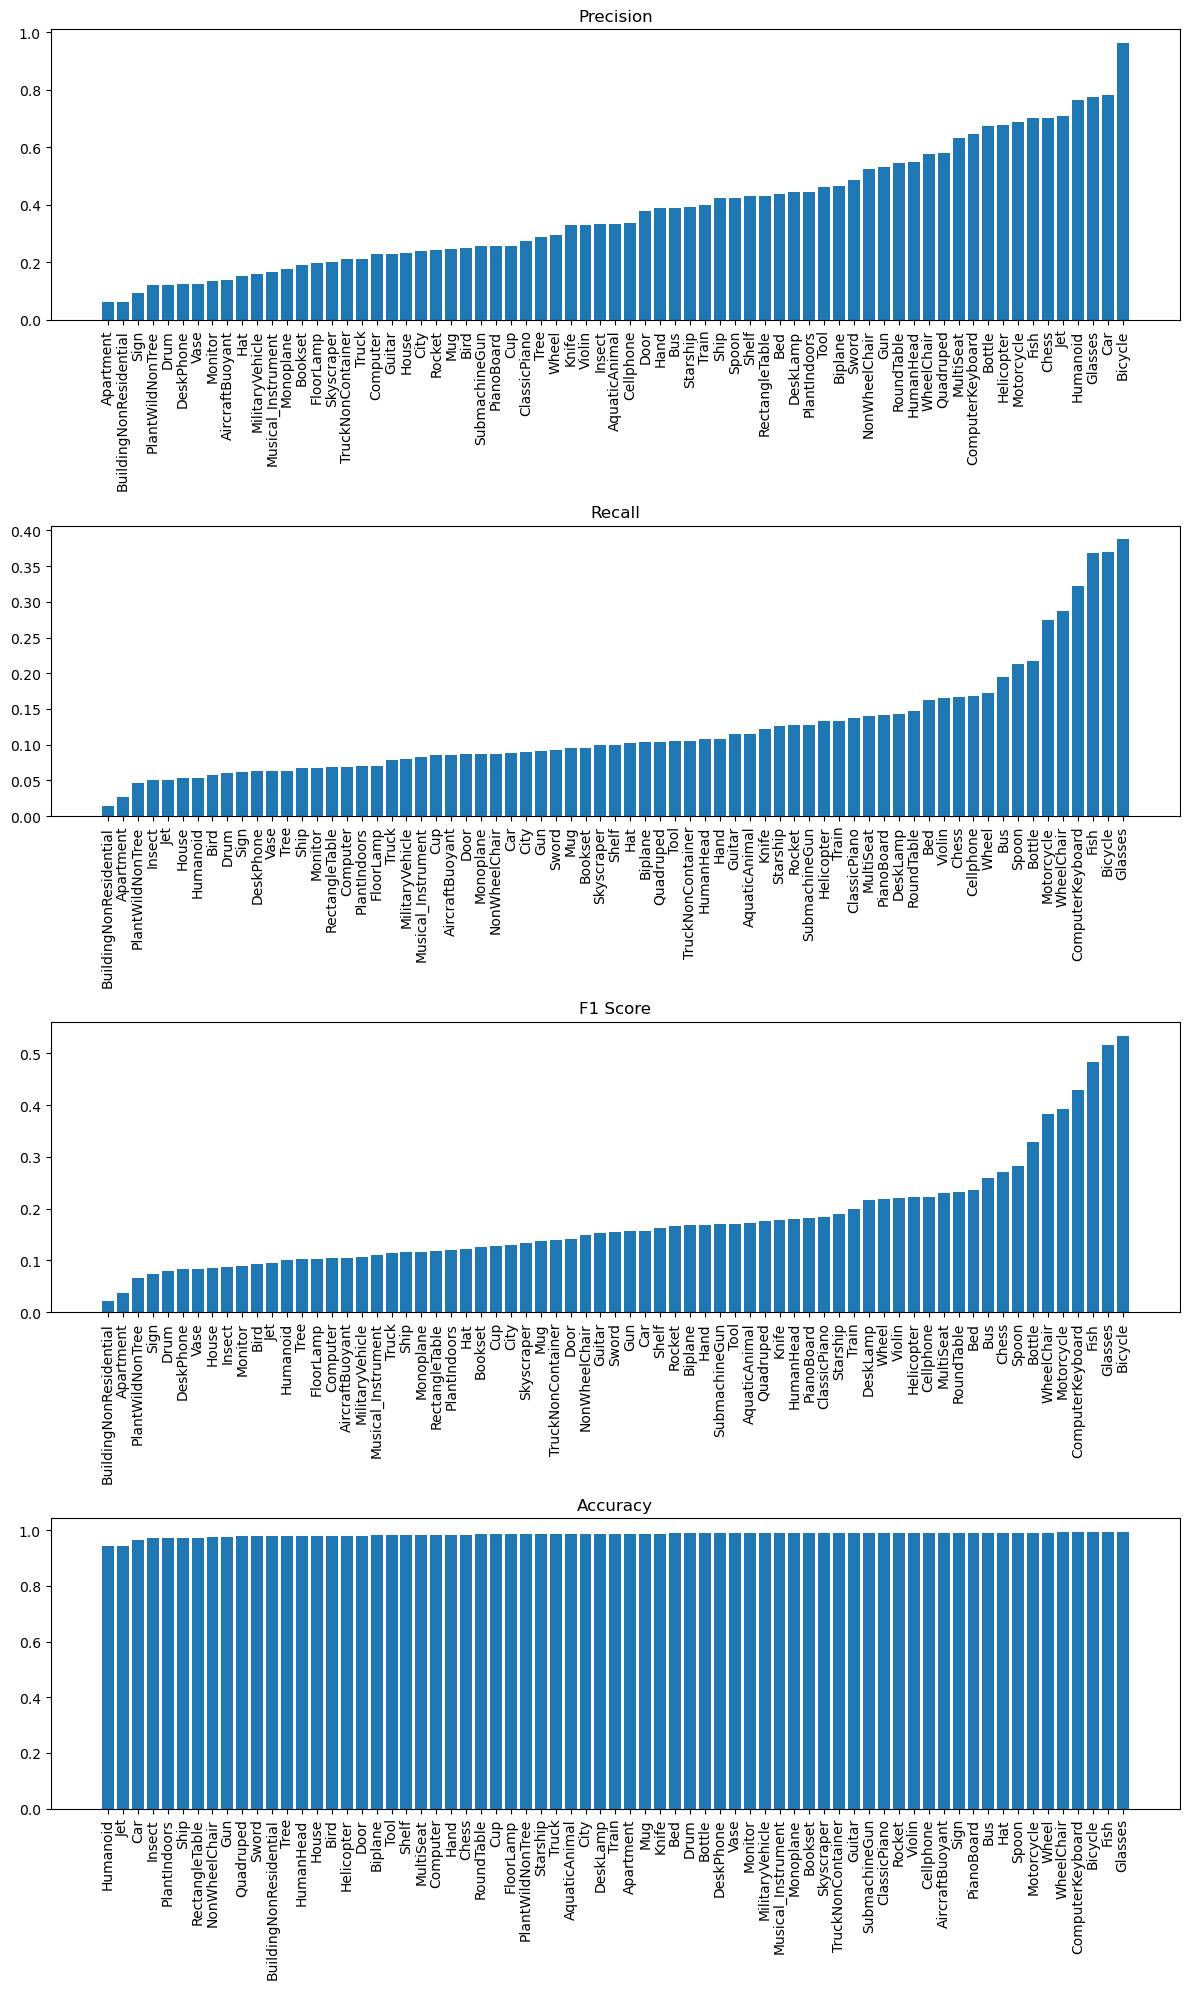

In [71]:
# Create separate plots for precision, recall, F1 score, accuracy
fig, axs = plt.subplots(4, figsize=(12, 20))

# Sort classes by precision and plot
sorted_classes = sorted(class_precision, key=class_precision.get)
axs[0].bar(sorted_classes, [class_precision[cls] for cls in sorted_classes])
axs[0].set_title('Precision')

# Sort classes by recall and plot
sorted_classes = sorted(class_recall, key=class_recall.get)
axs[1].bar(sorted_classes, [class_recall[cls] for cls in sorted_classes])
axs[1].set_title('Recall')

# Sort classes by F1 score and plot
sorted_classes = sorted(class_f1, key=class_f1.get)
axs[2].bar(sorted_classes, [class_f1[cls] for cls in sorted_classes])
axs[2].set_title('F1 Score')

# Sort classes by accuracy and plot
sorted_classes = sorted(class_accuracy, key=class_accuracy.get)
axs[3].bar(sorted_classes, [class_accuracy[cls] for cls in sorted_classes])
axs[3].set_title('Accuracy')

# Rotate x-axis labels for readability
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [72]:
import numpy as np

# Calculate overall average precision, recall, F1 score, sensitivity, specificity, accuracy
avg_precision = np.mean(list(class_precision.values()))
avg_recall = np.mean(list(class_recall.values()))
avg_f1 = np.mean(list(class_f1.values()))

# Calculate overall average sensitivity and specificity
avg_sensitivity = np.mean(list(class_sensitivity.values()))
avg_specificity = np.mean(list(class_specificity.values()))

avg_accuracy = np.mean(list(class_accuracy.values()))

print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')
print(f'Average Sensitivity: {avg_sensitivity}')
print(f'Average Specificity: {avg_specificity}')
print(f'Average Accuracy: {avg_accuracy}')


Average Precision: 0.3768885124619794
Average Recall: 0.12190222550508309
Average F1 Score: 0.17680205720206457
Average Sensitivity: 0.12190222550508309
Average Specificity: 0.9974399424263105
Average Accuracy: 0.9845087752694475
